# Basic Multi-agent Collaboration

A single agent can usually operate effectively using a handful of tools and a scoped domain, but even using powerful models like `gpt-4`, it can be less effective at using many tools. One way to improve your system's performance is through multi-agent collaboration. Each agent can specialize in a task or domain, and LangGraph can effectively orchestrate them to accomplish a larger goal. 

This notebook is inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155), by Wu, et. al.

This and other "advanced agent" notebooks are designed to show how you can implement certain design patterns in LangGraph. If the pattern suits your needs, we recommend combining it with some of the other fundamental patterns described elsewhere in the docs for best performance.

In [1]:
# %pip install -U langchain langchain_openai langsmith pandas

In [2]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

## Create tools

We will make 2 agents, 1 for plotting, and another for searching information on the web. Below are their tools:

In [3]:
from typing import List, Tuple, Union

import matplotlib.pyplot as plt
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_tool = TavilySearchResults(max_results=5)


@tool
def create_plot(
    data: list,
    labels: Union[List[str], None] = None,
    title: str = "Plot",
    xlabel: str = "X",
    ylabel: str = "Y",
    color: Union[str, List[str]] = "blue",
    plot_type: str = "bar",
) -> str:
    """
    Generates a bar or line plot from the provided data and returns the figure and axis objects.

    :param data: A list of numerical values for the bar heights or line points.
    :param labels: A list of strings for the bar or point labels. Default is None.
    :param title: Title of the plot. Default is 'Plot'.
    :param xlabel: Label for the X-axis. Default is 'X'.
    :param ylabel: Label for the Y-axis. Default is 'Y'.
    :param color: Color of the bars or line. Can be a single color or a list of colors. Default is 'blue'.
    :param figsize: Size of the figure as a tuple (width, height). Default is (10, 6).
    :param plot_type: Type of plot ('bar' or 'line'). Default is 'bar'.
    :return: Tuple containing the figure and axes objects.
    """
    if plot_type not in ["bar", "line"]:
        raise ValueError("Invalid plot_type. Expected 'bar' or 'line'.")

    fig, ax = plt.subplots(figsize=(10, 6))
    x_positions = range(len(data))

    if labels and len(labels) == len(data):
        plt.xticks(x_positions, labels)

    if plot_type == "bar":
        ax.bar(x_positions, data, color=color)
    elif plot_type == "line":
        ax.plot(x_positions, data, color=color, marker="o")  # 'o' for circular markers

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    return "Chart generated!"

## Create graph utilites

The following helper functions will simplify the code when it comes to actually constructing the graph.

You can skip ahead if you just want to see what the graph looks like.

In [4]:
import json

from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    ChatMessage,
    FunctionMessage,
    HumanMessage,
)

from langgraph.graph import END, StateGraph
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation


def _update_state(ai_message, name: str) -> dict:
    """The graph routes the logic based on the message type
    and the sender origin. We nee"""
    if isinstance(ai_message, FunctionMessage):
        result = ai_message
    else:
        result = HumanMessage(**ai_message.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


def add_agent_node(workflow: StateGraph, name: str, llm, tools):
    """Create an agent and add it to the graph builder."""
    functions = [format_tool_to_openai_function(t) for t in tools]

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you have the final answer, prefix your response with FINAL ANSWER."
                " You have access to the following tools: {tool_names}.",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )

    chain = (
        (lambda x: {**x, "intermediate_steps": []})
        | prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
        | llm.bind_functions(functions)
        | (lambda x: _update_state(x, name=name))
    )
    workflow.add_node(name, chain)


def call_tool(state):
    """This a helper class we have that is useful for running tools

    It takes in an agent action and calls that tool and returns the result."""
    messages = state["messages"]
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation from the function_call
    action = ToolInvocation(
        tool=last_message.additional_kwargs["function_call"]["name"],
        tool_input=json.loads(
            last_message.additional_kwargs["function_call"]["arguments"]
        ),
    )
    # We call the tool_executor and get back a response
    response = tool_executor.invoke(action)
    # We use the response to create a FunctionMessage
    function_message = FunctionMessage(content=str(response), name=action.tool)
    # We return a list, because this will get added to the existing list
    return {"messages": [function_message]}

## Create graph

Now that we've defined our tools and made some helper functions, will create the individual agents below and tell them how to talk to each other using LangGraph.

In [5]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain.agents import create_openai_functions_agent
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str


tools = [tavily_tool, create_plot]
tool_executor = ToolExecutor(tools)


workflow = StateGraph(AgentState)
llm = ChatOpenAI(model="gpt-4-1106-preview")
add_agent_node(
    workflow,
    "Researcher",
    llm,
    [tavily_tool],
)
add_agent_node(workflow, "Chart Generator", llm, [create_plot])
workflow.add_node("call_tool", call_tool)


# Either agent can decide to end
def should_continue(state):
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if "function_call" in last_message.additional_kwargs:
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        return "end"
    return "continue"


workflow.add_conditional_edges(
    "Researcher",
    should_continue,
    {"continue": "Chart Generator", "call_tool": "call_tool", "end": END},
)
workflow.add_conditional_edges(
    "Chart Generator",
    should_continue,
    {"continue": "Researcher", "call_tool": "call_tool", "end": END},
)
# We will assume that any time a tool is called, the researcher will choose what to do next
workflow.add_edge("call_tool", "Researcher")
workflow.set_entry_point("Researcher")
graph = workflow.compile()

## Invoke

With the graph created, you can invoke it!

HumanMessage(content="FINAL ANSWER:\n\nThe line graph of the UK's GDP over the past five years has been generated based on the estimated and provided figures:\n\n1. 2019: 2.238 trillion GBP\n2. 2020: 2.018 trillion GBP\n3. 2021: 2.14 trillion GBP\n4. 2022: 2.2 trillion GBP\n5. 2023: GDP growth of 0.1% in Q1 (Jan to Mar) - Note that the full-year value for 2023 is an estimate based on Q1 data and should be treated with caution.\n\nPlease note that the 2023 figure is not the full-year GDP but rather the growth rate for the first quarter. The actual GDP value for 2023 will be determined at the end of the year. The graph provides a visual representation of the GDP trend over the past five years, with an observable dip in 2020 due to the economic impact of the COVID-19 pandemic, followed by a recovery in subsequent years.", name='Chart Generator')

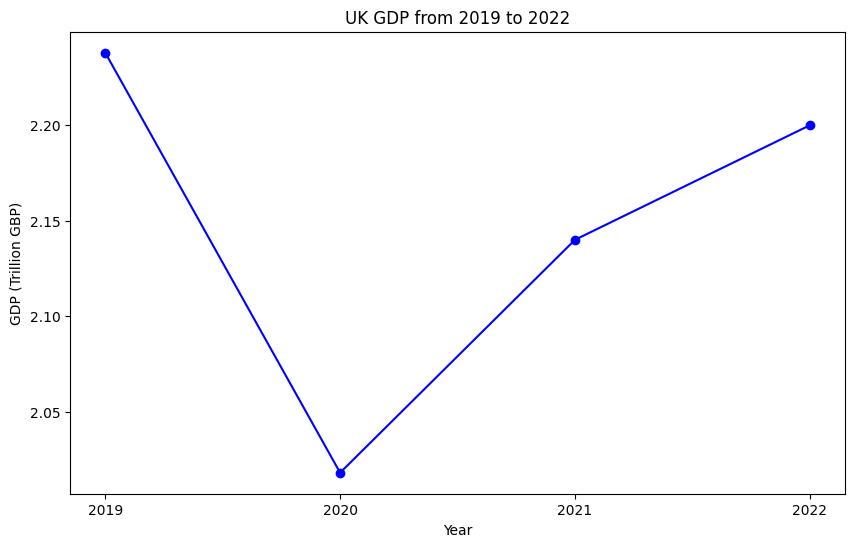

In [6]:
result = graph.invoke(
    {
        "messages": [
            HumanMessage(
                content="Fetch the UK's GDP over the past 5 years, then draw a line graph of it."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
result["messages"][-1]